In [1]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install bert
!pip install peft

In [2]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.models import Model
import bert
from transformers import BertTokenizer,AutoModelForMaskedLM
from transformers import AdamW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import inspect
import json
import torch
from tqdm.auto import tqdm
from transformers import AutoModelForMaskedLM, AutoTokenizer
from transformers import AutoTokenizer, AutoModel


Loading data

In [3]:
df = pd.read_csv("data.csv")

df = df.set_index("id")
print(df.shape)
print("Displaying First Few Porducts:")
df.head(5)

(1666, 21)
Displaying First Few Porducts:


,slug,title,imgs,brand,category,vendor,used,address,availability,currency,...,discounted_price,specifications,description,delivery_fee,delivery_details,warranty,warranty_type,average_rating,num_ratings,reviews
id,,,,,,,,,,,,,,,,,,,,,
0,https://www.mega.pk/mobiles_products/23522/Not...,Nothing Phone 1 8GB RAM 256GB Storage Non PTA ...,['https://www.mega.pk/items_images/Nothing+Pho...,NaN,Mobile,MEGA.PK,0,"Office 11, 12, 14 Basement Ahmed Center, I-8 M...",NaN,PKR,...,NaN,"{'RAM': '8GB', 'Memory quantity': '', 'Interna...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,https://www.mega.pk/mobiles_products/23458/Opp...,Oppo F21 Pro 8GB Ram 128GB Storage 5G PTA Appr...,['https://www.mega.pk/items_images/Oppo+F21+Pr...,OPPO,Mobile,MEGA.PK,0,"Office 11, 12, 14 Basement Ahmed Center, I-8 M...",NaN,PKR,...,NaN,"{'RAM': '8gb', 'Memory quantity': '', 'Interna...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
2,https://www.mega.pk/mobiles_products/24393/Tec...,Tecno Spark 10,['https://www.mega.pk/items_images/Tecno+Spark...,Tecno,Mobile,MEGA.PK,0,"Office 11, 12, 14 Basement Ahmed Center, I-8 M...",Coming Soon,PKR,...,NaN,"{'RAM': '4GB,8GB', 'Memory quantity': '', 'Int...",NaN,NaN,NaN,1 year,NaN,NaN,NaN,[]
3,https://www.mega.pk/mobiles_products/24259/Viv...,Vivo V27 5G,['https://www.mega.pk/items_images/Vivo+V27+5G...,Vivo,Mobile,MEGA.PK,0,"Office 11, 12, 14 Basement Ahmed Center, I-8 M...",Coming Soon,PKR,...,NaN,"{'RAM': '8GB,12GB', 'Memory quantity': '', 'In...",NaN,NaN,NaN,1 year,NaN,NaN,NaN,[]
4,https://www.mega.pk/mobiles_products/24204/App...,Apple Iphone 15 Pro Max,['https://www.mega.pk/items_images/Apple+Iphon...,Apple,Mobile,MEGA.PK,0,"Office 11, 12, 14 Basement Ahmed Center, I-8 M...",Coming Soon,PKR,...,NaN,"{'RAM': '8GB', 'Memory quantity': '', 'Interna...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


generating sentences code

In [4]:
def create_sentence(
    title = None,
    description = None,
    currency = None,
    original_price = None,
    discounted_price = None,
    brand = None,
    average_rating = None,
    num_ratings = None,
    reviews = None,
    category = None,
    availability = None,
    vendor = None,
    specifications = None,
    used = None,
    warranty = None,
    warranty_type = None,
):

    sentences = []

    def simple_add(name, msg="__"):
        if not pd.isna(name):
            sentences.append(msg.replace("__", str(name)))

    simple_add(category, "Category is __")
    simple_add(brand, "Brand is __")
    # simple_add(vendor, "Its vendor is __")

    if not pd.isna(discounted_price):
        sentences.append(f"Price is {original_price} {currency}, with discouted price of {discounted_price}")
    elif not pd.isna(original_price):
        sentences.append(f"Price is {original_price} {currency}")

    simple_add(average_rating, "Average rating: __")
    simple_add(num_ratings, "Total Ratings: __")

    if not pd.isna(reviews):
        # sentences.append(f"It has a total of {len(reviews)}")
        pass

    simple_add(availability, "It is __")
    if not pd.isna(warranty):
        sentences.append(f"It has a warranty for {warranty}")
    simple_add(warranty_type, "It has __")

    if not pd.isna(used):
        if used == 0:
            sentences.append("It is a used product")
        else:
            sentences.append("It is a new product")

    simple_add(description)

    invalids = {"-", "N/A", "NA", "N\\A"}
    specs = []
    for k, v in eval(specifications).items():
        if v not in invalids and "https://" not in v:
            specs.append(f"{k} is {v}")
    if len(specs) > 0:
        sentences.append("The product's " + " and ".join(specs))

    # for k, v in parsed_specs.items():
    #     sentences.append(f"{v[0]} {k}")

    return f'{title.strip()}. {". ".join(sentences)}.'.lower()

In [5]:
load = False

if load:
    # LOADING
    with open('sentences.json', 'rb') as f:
        sentences = json.load(f)
else:
    # CREATING
    sentences = []
    for i in range(len(df)):
        row = df.iloc[i]
        sent = create_sentence(
            *[row[i] for i in inspect.getfullargspec(create_sentence).args]
        )
        sentences.append(sent)
    # SAVING
    with open('sentences.json', 'w') as f:
        json.dump(sentences, f)

In [6]:
sentences[0]

"nothing phone 1 8gb ram 256gb storage non pta 5g black. category is mobile. price is 129999.0 pkr. it is a used product. the product's ram is 8gb and memory quantity is  and internal storage space is 256gb and main camera pixels is 50 mp, f/1.9, 24mm (wide), 1/1.56 and battery capacity is li-po 4500 mah, non-removable and screen size is 6.55 inches and 5g support is yes and finger print is yes and display technology is oled, 1b colors, 120hz, hdr10+, 500 nits (typ), 700 nits (peak) and display is 6.55 inches oled, 1b colors and number of colours is 1b and scratch resistant display is  and screen resolution is 1080 x 2400 pixels and pixel density is 402 ppi and dual screens is  and sd card is yes and sdio is  and compatible memory cards is 128gb 8gb ram, 256gb 8gb ram, 256gb 12gb ram and maximum amount of memory is  and built-in camera is yes and auto focus is yes and built-in flash is yes and digital zoom (still image) is yes and maximum resolution (still) is 1080p 30fps and number of

Defining model and tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-TinyBERT-L6-v2')
model = AutoModelForMaskedLM.from_pretrained('sentence-transformers/paraphrase-TinyBERT-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForMaskedLM were not initialized from the model checkpoint at sentence-transformers/paraphrase-TinyBERT-L6-v2 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

In [7]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-TinyBERT-L6-v2')
model = AutoModelForMaskedLM.from_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_tinybert_model')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForMaskedLM were not initialized from the model checkpoint at sentence-transformers/paraphrase-TinyBERT-L6-v2 and are newly initialized: ['cls.predictions.bias', 'cls.prediction

Analysis of model

In [8]:
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): lora.Embedding(
        (base_layer): Embedding(30522, 768, padding_idx=0)
        (lora_dropout): ModuleDict(
          (default): Dropout(p=0.4, inplace=False)
        )
        (lora_A): ModuleDict()
        (lora_B): ModuleDict()
        (lora_embedding_A): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 16x30522])
        (lora_embedding_B): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 768x16])
      )
      (position_embeddings): lora.Embedding(
        (base_layer): Embedding(512, 768)
        (lora_dropout): ModuleDict(
          (default): Dropout(p=0.4, inplace=False)
        )
        (lora_A): ModuleDict()
        (lora_B): ModuleDict()
        (lora_embedding_A): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 16x512])
        (lora_embedding_B): ParameterDict(  (default): Parameter containin

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [10]:
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): lora.Embedding(
        (base_layer): Embedding(30522, 768, padding_idx=0)
        (lora_dropout): ModuleDict(
          (default): Dropout(p=0.4, inplace=False)
        )
        (lora_A): ModuleDict()
        (lora_B): ModuleDict()
        (lora_embedding_A): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 16x30522])
        (lora_embedding_B): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 768x16])
      )
      (position_embeddings): lora.Embedding(
        (base_layer): Embedding(512, 768)
        (lora_dropout): ModuleDict(
          (default): Dropout(p=0.4, inplace=False)
        )
        (lora_A): ModuleDict()
        (lora_B): ModuleDict()
        (lora_embedding_A): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 16x512])
        (lora_embedding_B): ParameterDict(  (default): Parameter containin

Implementing LORA

In [ ]:
# Define target modules for PEFT
# target_modules=[
#     "q_lin",
#     "k_lin",
#     "v_lin","out_lin","ffn.lin1","ffn.lin2"]

target_modules = [
    'word_embeddings',
    'position_embeddings',
    'token_type_embeddings',
    'embedding_transformation',
    'query',
    'key',
    'value',
    'output.dense',
    'intermediate.dense',
    'output.dense',

]

from peft import (
    get_peft_model,
    LoraConfig,
    TaskType
)

# LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=16,
    lora_dropout=0.4,
    target_modules=target_modules,
    bias="all")

# load LoRA model and print parameters
lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

trainable params: 1,944,058 || all params: 68,847,610 || trainable%: 2.8237


In [ ]:
model=lora_model

In [ ]:


model.print_trainable_parameters()

trainable params: 1,944,058 || all params: 68,847,610 || trainable%: 2.8237


Freezing model layers

In [ ]:
total_layers = len(list(model.parameters()))
layers_to_freeze = int(total_layers * 0.9999)

for i, param in enumerate(model.parameters()):
    if i < layers_to_freeze:
        param.requires_grad = False

# Check which layers are frozen
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.model.bert.embeddings.word_embeddings.base_layer.weight | Requires Grad: False
Layer: base_model.model.bert.embeddings.word_embeddings.lora_embedding_A.default | Requires Grad: False
Layer: base_model.model.bert.embeddings.word_embeddings.lora_embedding_B.default | Requires Grad: False
Layer: base_model.model.bert.embeddings.position_embeddings.base_layer.weight | Requires Grad: False
Layer: base_model.model.bert.embeddings.position_embeddings.lora_embedding_A.default | Requires Grad: False
Layer: base_model.model.bert.embeddings.position_embeddings.lora_embedding_B.default | Requires Grad: False
Layer: base_model.model.bert.embeddings.token_type_embeddings.base_layer.weight | Requires Grad: False
Layer: base_model.model.bert.embeddings.token_type_embeddings.lora_embedding_A.default | Requires Grad: False
Layer: base_model.model.bert.embeddings.token_type_embeddings.lora_embedding_B.default | Requires Grad: False
Layer: base_model.model.bert.embeddings.LayerNorm.weigh

In [ ]:
model.print_trainable_parameters()

trainable params: 768 || all params: 68,847,610 || trainable%: 0.0011


Tokenizing text data

In [ ]:

inputs = tokenizer(
    sentences,
    max_length=512,
    truncation=True,
    padding='max_length',
    return_tensors='pt'
)

In [ ]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
inputs['labels'] = inputs['input_ids'].detach().clone()
inputs

{'input_ids': tensor([[  101,  2498,  3042,  ..., 21716, 15141,   102],
        [  101,  6728,  6873,  ...,  1013, 13109,   102],
        [  101,  8915,  2278,  ...,  2003,  1998,   102],
        ...,
        [  101,  6522, 18546,  ...,     0,     0,     0],
        [  101, 12418, 16021,  ...,     0,     0,     0],
        [  101, 12418, 16021,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([[  101,  2498,  3042,  ..., 21716, 15141,   102],
        [  101,  6728,  6873,  ...,  1013, 13109,   102],
        [  101,  8915, 

Masking the input_ids


In [ ]:
random_tensor = torch.rand(inputs['input_ids'].shape)
random_tensor.shape

torch.Size([1666, 512])

In [ ]:
masked_tensor = (random_tensor < 0.15)*(inputs['input_ids'] != 101)*(inputs['input_ids'] != 102)*(inputs['input_ids'] != 0)
masked_tensor

tensor([[False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False]])

In [ ]:

# getting all those indices from each row which are set to True, i.e. masked.
nonzeros_indices = []
for i in range(len(masked_tensor)):
    nonzeros_indices.append(torch.flatten(masked_tensor[i].nonzero()).tolist())

In [ ]:

# setting the values at those indices to be a MASK token (103) for every row in the original input_ids.
for i in range(len(inputs['input_ids'])):
    inputs['input_ids'][i, nonzeros_indices[i]] = 103

Pytorch Dataset and Dataloader


In [ ]:
class BookDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, index):
        input_ids = self.encodings['input_ids'][index]
        labels = self.encodings['labels'][index]
        attention_mask = self.encodings['attention_mask'][index]
        token_type_ids = self.encodings['token_type_ids'][index]
        return {
            'input_ids': input_ids,
            'labels': labels,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids
        }

In [ ]:
dataset = BookDataset(inputs)


In [ ]:

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=12,
    shuffle=True
)

Model parameters


In [ ]:

epochs = 10
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training model

In [ ]:

model.train()

for epoch in range(epochs):
    loop = tqdm(dataloader)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        loop.set_description("Epoch: {}".format(epoch))
        loop.set_postfix(loss=loss.item())

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

Prediction

In [ ]:
import torch
from transformers import BertTokenizer, TFBertForMaskedLM

# Load the fine-tuned model and tokenizer
# model_path = "fine_tuned_bert"  # change this to your model's path
# tokenizer = BertTokenizer.from_pretrained(model_path)
# model = TFBertForMaskedLM.from_pretrained(model_path)

# Set the model in evaluation mode
# model.eval()

# Input text with [MASK] token
text = "nothing phone 1 8gb ram 256gb [MASK] non pta 5g black. category is mobile. price is 129999.0 pkr. it is a used product. the product's ram is 8gb and memory quantity is"

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"]

# Get the mask token index
mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]

# Make predictions
with torch.no_grad():
    outputs = model(input_ids.to(device))
    logits = outputs.logits

# Get the predicted token ID for the [MASK] token
mask_token_logits = logits[0, mask_token_index, :]
predicted_token_id = torch.argmax(mask_token_logits, axis=-1)

# Decode the predicted token ID to get the predicted word
predicted_token = tokenizer.decode(predicted_token_id)

# Replace [MASK] with the predicted token in the input text
predicted_text = text.replace(tokenizer.mask_token, predicted_token)

print(f"Original text: {text}")
print(f"Predicted text: {predicted_text}")


Original text: nothing phone 1 8gb ram 256gb [MASK] non pta 5g black. category is mobile. price is 129999.0 pkr. it is a used product. the product's ram is 8gb and memory quantity is
Predicted text: nothing phone 1 8gb ram 256gb deserts non pta 5g black. category is mobile. price is 129999.0 pkr. it is a used product. the product's ram is 8gb and memory quantity is


Getting sentence and word embeddings from trained model

In [37]:
# device = torch.device('cpu')
# model.to(device)

# Initialize lists to store embeddings
# cls_embeddings = []
# average_pooling_embeddings = []

# Process each sentence
for sentence in sentences[180:190]:
    # Tokenize input
    inputs = tokenizer(sentence, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the logits
    logits = outputs.logits  # Shape: (batch_size, sequence_length, vocab_size)

    # Option 1: Extracting [CLS] token embedding
    cls_embedding = logits[:, 0, :]  # Shape: (batch_size, vocab_size)

    # Option 2: Average pooling across sequence length
    average_pooling = torch.mean(logits, dim=1)  # Shape: (batch_size, vocab_size)

    # Convert tensors to numpy arrays if needed
    cls_embedding_np = cls_embedding.cpu().numpy()
    average_pooling_np = average_pooling.cpu().numpy()

    # Append embeddings to lists
    cls_embeddings.append(cls_embedding_np)
    average_pooling_embeddings.append(average_pooling_np)

# Print embeddings (example for first sentence)
print("CLS Token Embedding (First Sentence):")
print(cls_embeddings[0])
print("\nAverage Pooling Embedding (First Sentence):")
print(average_pooling_embeddings[0])

CLS Token Embedding (First Sentence):
[[-0.05532289 -1.4885461  -1.6383278  ... -1.0800583  -0.9389112
  -0.5653467 ]]

Average Pooling Embedding (First Sentence):
[[ 0.00815307 -0.9043076  -0.9710755  ... -1.0265007  -0.91308033
  -0.93418205]]


In [34]:
np.array(average_pooling_embeddings).shape


(140, 1, 30522)

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/fine_tuned_tinybert_model')


In [38]:

def plot_embeddings(X, extra_label='extra', by=None, skip=[]):
    if by is None:
        labels = (df.vendor + " - " + df.category).values.tolist()  # Adjust df according to your DataFrame structure
        print(labels)
    else:
        labels = df[by].values.tolist()  # Adjust df according to your DataFrame structure

    labels_ = np.array(labels + [extra_label] * (len(X) - len(labels)))
    print(len(labels_))
    labels_list = labels_.tolist()

    # Concatenate two segments of the list
    labels_list = labels_list[:110] + labels_list[1000:1010]+ labels_list[1500:1510] + labels_list[800:810]+ labels_list[180:190]

    # Convert back to a numpy array if needed
    labels_ = np.array(labels_list)

    # Create mask based on categories to skip
    mask = np.array([label not in skip for label in labels_] + [True] * (len(X) - len(labels)))

    # Apply mask to X and labels_
    X = X[mask]
    labels_ = labels_[mask]

    # Reshape X for PCA if necessary
    X = X.reshape(X.shape[0], -1)  # Reshape to (number of samples, 30000)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    categories = np.unique(labels_)
    colors = plt.cm.get_cmap('tab10', len(categories))

    for i, category in enumerate(categories):
        points = X_pca[labels_ == category]
        color = colors(i)
        plt.scatter(points[:, 0], points[:, 1], color=color, label=category)

    plt.legend()
    plt.show()

    return None

1666


<ipython-input-38-9e25e9598dfe>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


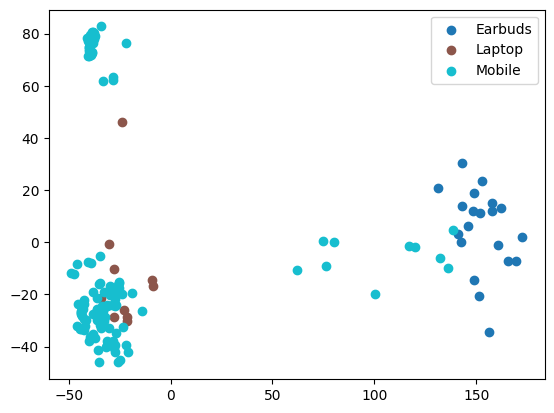

In [39]:
plot_embeddings(np.array(average_pooling_embeddings),by='category')

1666


<ipython-input-38-9e25e9598dfe>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


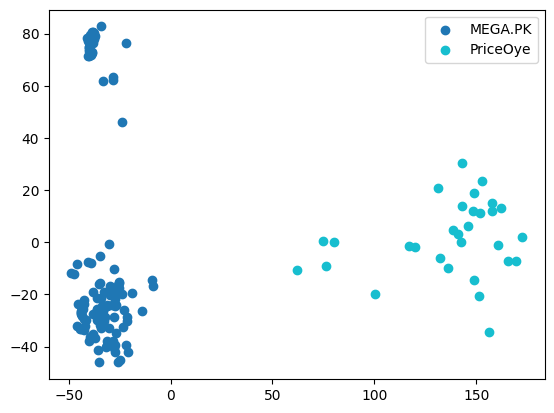

In [41]:
plot_embeddings(np.array(average_pooling_embeddings),by='vendor')

1666


<ipython-input-38-9e25e9598dfe>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


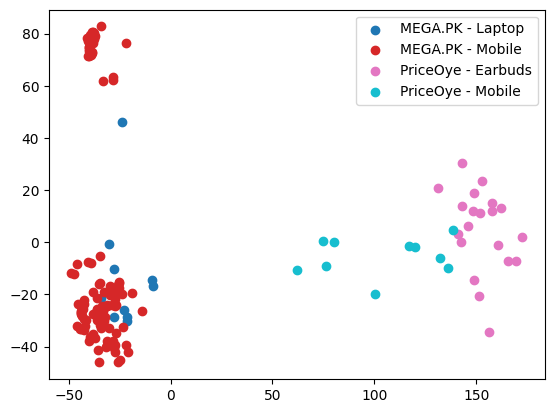

In [42]:
plot_embeddings(np.array(average_pooling_embeddings))